# Classifier of tweets
Twitter is an online news and social networking service on which users post and interact with messages known as "tweets". Tweets were originally restricted to 140 characters, but on November 7, 2017, this limit was doubled. Registered users can post, like, and retweet tweets, but unregistered users can only read them.
The service's application programming interface (API) allows other web services and applications to integrate with Twitter. There are a lot of possibilities that Twitter API gives. In this assignment we will see some of them. 
The most important library that we use is Tweepy which is needed for accessing the Twitter API.


### Overview
First of all, we need a Twitter account and we have to create a Twitter App (a mechanism that provides Twitter for developers who want to access Twitter content through programs). When we create a Twitter App, we are provided with a series of keys that we have to use in the program to identify ourselves.

We are extracting tweets of 4 accounts in Twitter (two accounts are similar and two others are not). The amount of tweets that we are considering is 500 per person, which is enough to obtain representative results. During all the following work, we will consider only the text of tweets. In addition, to train our models we split existing tweets into train (70%) and test (30%) subsets, which are selected randomly.

We will develop three experiment. The two first correspond to the ones specified in the assignment, which tackle the problem of classifying a pair of similar people and a pair of different people. The third will attempt to classify between these four people at the same time. The latter adds extra complexity to the model so less accuracy is expected.

We train a support vector machine classifier (SVM) for which we give a set of training examples, each marked as belonging to one person. A SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. It is worth noticing that in the third experiment we will do multi class classification, however, SVM can also be used for multiclass classification using some internal changes provided in the library.

In the next step, we compare results for three groups (first and second users, third and forth users, and all four users together) using SVC with linear, RBF and polynomial kernel, as well as different values for the penalty parameter C, degree of the polynomial kernel function and kernel coefficient gamma. As an extension, we also make a quick comparison with other well known methods like Naive Bayes.

Finally we have made use of confusion matrixes. In a confusion matirx the diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better because it means that predictor was successful. This allows us to make an accurate analysis of the performance of the trained model, and it is specially intersting when classifying different classes.

In the last part of the assignment, we have made basic analysis of feelings. For this we have used lists of positive and negative terms created by Bing and Liu. As a result we got the global percentage of positive and negative terms in the tweets of each person.

At the begginig of the script we install needed libraries.

In [21]:
!pip install tweepy
!pip install TextBlob

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


After that we import libraries that are required.   
Also we define a function for building confusion matrix.

In [22]:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Here we consume  Twitter's API. For it we need the following information:
* __Consumer Key (API Key)__ and __Consumer Secret (API Secret)__ which authenticate the app that is using the Twitter API.
* __Access Token__ and __Access Token Secret__ which authenticate the user.

Also at this point we create a function to setup the Twitter API.

In [23]:
# Consume:
CONSUMER_KEY    = 'p7cpkuv0zPQaBd3X1jqIHnKn9'
CONSUMER_SECRET = '6APZspM93n5CLU9nvQSo3hSl5YevnZm2Bah3vGa38GjML5THED'

# Access:
ACCESS_TOKEN  = '1050397775572160512-9GvDeD9e9UIJVkkTBPYk3LApmLsqkk'
ACCESS_SECRET = 'qWoZt4Ul7g3FytwvP1pnkyXhFx8n3CgQNFvCyRbbMtsSt'


# API's setup:
def twitter_setup():
    """
    Utility function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

Now we will use Tweepy's function to extract the quantity of count tweets.

For this assignment we have chosen 4 accounts in Twitter (two of them are similar and two others are not):
* __@TheEllenShow__ is a twitter of an American comedian, television host, actress, writer and producer.
* __@ConanOBrien__ is a twitter of an American television host, comedian, writer, and producer.

* __@elonmusk__ is a twitter of a technology entrepreneur, investor, and engineer. He is the (co-)founder of SpaceX, Tesla, Inc., Neuralink and PayPal.
* __@EmmaWatson__ is a twitter of an English actress, model, and activist. She played the major role in all eight Harry Potter films.

In each request Twitter will allow us to extract maximum 200 tweets, because of that we have used the Cursor object in order to help make pagination easier and require less code. We specify that we want to extract 500 tweets per person.  
__tweet_mode="extended"__ and __status.full_text__ make results include the full text of the long tweets.

In [24]:
# We create an extractor object:
extractor = twitter_setup()
tweets1 = []
tweets2 = []
tweets3 = []
tweets4 = []

list_people = ['TheEllenShow','ConanOBrien','elonmusk','EmmaWatson']

for status in tweepy.Cursor(extractor.user_timeline, screen_name='TheEllenShow', tweet_mode="extended").items(500):
    tweets1.append(status.full_text)
    
for status in tweepy.Cursor(extractor.user_timeline, screen_name='ConanOBrien', tweet_mode="extended").items(500):
    tweets2.append(status.full_text)
    
for status in tweepy.Cursor(extractor.user_timeline, screen_name='elonmusk', tweet_mode="extended").items(500):
    tweets3.append(status.full_text)
    
for status in tweepy.Cursor(extractor.user_timeline, screen_name='EmmaWatson', tweet_mode="extended").items(500):
    tweets4.append(status.full_text)

list_tweets = [tweets1,tweets2,tweets3,tweets4]
 
print("Number of tweets extracted: "+str(len(tweets1))+","+str(len(tweets2))+","+str(len(tweets3))+","+str(len(tweets4))+".\n")

Number of tweets extracted: 500,500,500,500.



We create labels to specify to whom belongs each tweet.

In [25]:
person1 = 1*np.ones(len(tweets1))
person2 = 2*np.ones(len(tweets2))
person3 = 3*np.ones(len(tweets3))
person4 = 4*np.ones(len(tweets4))

Function __train_test_split__ splits arrays into random train and test subsets.

We specify __test_size__ equal to 0.3 and __train_size__ is automatically set to the complement of the test size (0.7).
Also we specify __random_state__ to make results easier to reproduce. If we don't do it, every time we execute our code, a new random value will be generated and the train and test datasets would have different values each time.    
Important to mention that we shuffle our arrays (by default this parameter is set to True).

In [26]:
tweets1_train, tweets1_test, person1_train, person1_test = train_test_split(tweets1, person1, test_size=0.3, random_state=42)
tweets2_train, tweets2_test, person2_train, person2_test = train_test_split(tweets2, person2, test_size=0.3, random_state=42)
tweets3_train, tweets3_test, person3_train, person3_test = train_test_split(tweets3, person3, test_size=0.3, random_state=42)
tweets4_train, tweets4_test, person4_train, person4_test = train_test_split(tweets4, person4, test_size=0.3, random_state=42)

At this point we create a function which:
1. shuffles the training set because if firstly there are 500 tweets of one person, after 500 tweets of another, etc., it can be understood by the model as a consistent pattern and corrupt the learning process.
2. vectorizes the collection. For this we used the library scikit-learn which provides a vectorizer utility for TF/IDF. We have decided not to limit the number of words since we are considering small texts and there are many words that appear rarely but that may have a significant impact. 
__fit__	learns vocabulary and idf from training set.   
__transform__ transforms documents to document-term matrix.    
__stop_words__ removes stop words in English (for example, the, is, at, which, and on).   
3. checks results using SVC with linear kernel, SVC with RBF kernel, SVC with polynomial kernel and Gaussian Naive Bayes.   
The objective of a SVC (Support Vector Classifier) is to fit to the data we provide, returning a "best fit" hyperplane that divides, or categorizes, our data. From there, after getting the hyperplane, we can then feed some features to our classifier to see what the "predicted" class is. 
4. and calls a function which plots a confusion matrix.

Also we have created a function for printing percentage of __correct__ predictions.

In [27]:
def analyse(tweets_train, tweets_test, person_train, person_test, classes):
    tweets_train, person_train = shuffle(tweets_train, person_train, random_state=42)
    tweets_test, person_test = shuffle(tweets_test, person_test, random_state=42)

    vectorizer = TfidfVectorizer(stop_words='english') 
    vectorizer.fit(tweets_train)
    vectorizer.fit(tweets_test)

    tfidf_train = vectorizer.transform(tweets_train)
    tfidf_test = vectorizer.transform(tweets_test)
    
    names = ['SVC, Linear Kernel','SVC, Poly Kernel','SVC, RBF Kernel','Naive Bayes']
    classifiers = [SVC(kernel='linear'),SVC(kernel='poly'),SVC(kernel='rbf'), GaussianNB()]
    
    accuracy = []

    for clf,name in zip(classifiers,names):
        clf.fit(tfidf_train.toarray(), person_train)

        y_test = person_test
        y_pred = clf.predict(tfidf_test.toarray())
        df = pd.DataFrame()
        df["actual"] = y_test
        df["predicted"] = y_pred
        correct = df[df["actual"] == df["predicted"]]

        accuracy.append(len(correct)/len(person_test))
        print(f"{name}: {len(correct)/len(person_test)*100:.2f}%") #to print percentage of correct predictions
        print()

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test, y_pred)
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes, title=name)
        plt.show()


    model_names = ['Linear Kernel','Poly Kernel','RBF Kernel','Naive Bayes']
    n_models = len(model_names)

    plt.bar(np.arange(n_models),accuracy)
    plt.xticks(np.arange(n_models), model_names)
    plt.ylim(0,1);

### FOR SIMILAR PEOPLE

Here we concatenate our arrays of first and second users in order to work with all data at the same time. After that we call the function __analyse__ which shuffles an array, vectorizes the collection and checks results using SVC with linear kernel, SVC with RBF kernel, SVC with polynomial kernel and Naive Bayes, and calls the function which plots a confusion matrix.

SVC, Linear Kernel: 87.33%



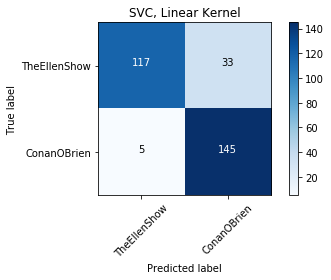

SVC, Poly Kernel: 50.00%



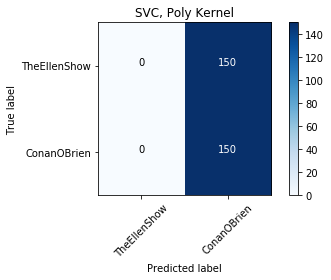

SVC, RBF Kernel: 53.67%



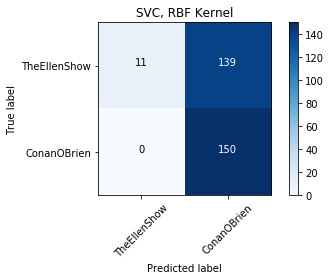

Naive Bayes: 76.67%



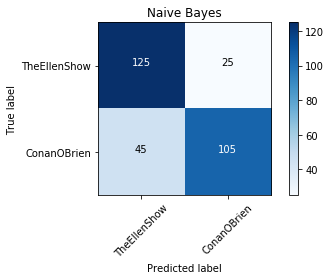

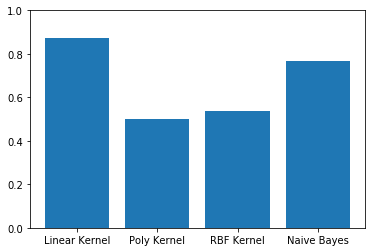

In [28]:
tweets_train = np.concatenate((tweets1_train, tweets2_train))
tweets_test = np.concatenate((tweets1_test, tweets2_test))
person_train = np.concatenate((person1_train, person2_train))
person_test = np.concatenate((person1_test, person2_test))
analyse(tweets_train, tweets_test, person_train, person_test, classes=('TheEllenShow','ConanOBrien'))

### FOR NOT SIMILAR PEOPLE

Here we concatenate our arrays of third and forth users in order to work with all data at the same time. After that we call the function __analyse__ which shuffles an array, vectorizes the collection and checks results using SVC with linear kernel, SVC with RBF kernel, SVC with polynomial kernel and Gaussian Naive Bayes, and calls the function which plots a confusion matrix.

SVC, Linear Kernel: 87.67%



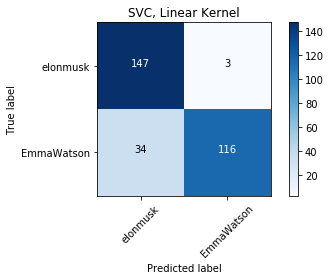

SVC, Poly Kernel: 50.33%



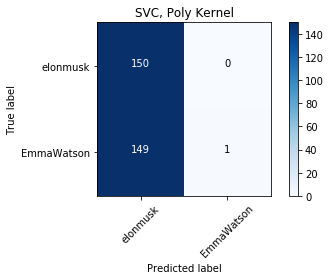

SVC, RBF Kernel: 58.33%



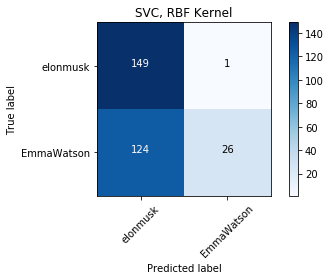

Naive Bayes: 89.33%



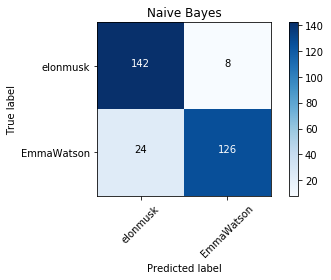

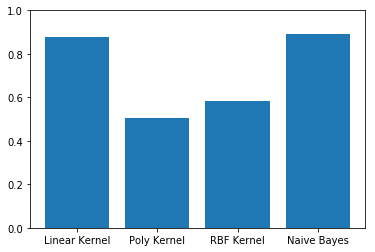

In [29]:
tweets_train = np.concatenate((tweets3_train, tweets4_train))
tweets_test = np.concatenate((tweets3_test, tweets4_test))
person_train = np.concatenate((person3_train, person4_train))
person_test = np.concatenate((person3_test, person4_test))
analyse(tweets_train, tweets_test, person_train, person_test, classes=('elonmusk','EmmaWatson'))

### FOR ALL PEOPLE

Here we concatenate our arrays of all users in order to work with all data at the same time. After that we call the function __analyse__ which shuffles an array, vectorizes the collection and checks results using SVC with linear kernel, SVC with RBF kernel, SVC with polynomial kernel and Gaussian Naive Bayes, and calls the function which plots a confusion matrix.

SVC, Linear Kernel: 78.50%



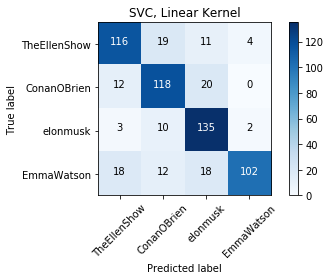

SVC, Poly Kernel: 25.00%



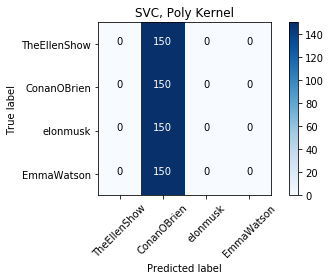

SVC, RBF Kernel: 37.33%



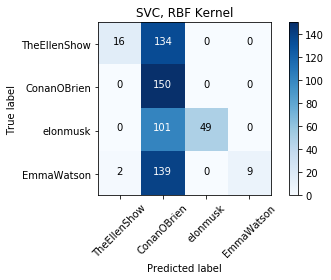

Naive Bayes: 71.00%



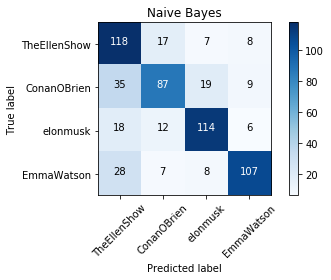

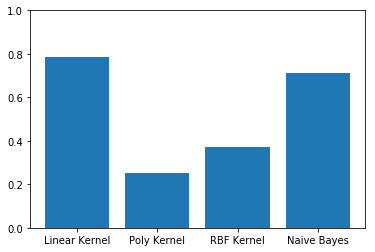

In [30]:
tweets_train = np.concatenate((tweets1_train, tweets2_train, tweets3_train, tweets4_train))
tweets_test = np.concatenate((tweets1_test, tweets2_test, tweets3_test, tweets4_test))
person_train = np.concatenate((person1_train, person2_train, person3_train, person4_train))
person_test = np.concatenate((person1_test, person2_test, person3_test, person4_test))
analyse(tweets_train, tweets_test, person_train, person_test, classes=('TheEllenShow','ConanOBrien','elonmusk','EmmaWatson'))

From these results we conclude that the most applicable machine learning algorithm for our problem is SVC with linear kernel.   
Now we will see results with applying some parameters.

In [31]:
def analyse(tweets_train, tweets_test, person_train, person_test, classes):
    tweets_train, person_train = shuffle(tweets_train, person_train, random_state=42)
    tweets_test, person_test = shuffle(tweets_test, person_test, random_state=42)

    vectorizer = TfidfVectorizer(stop_words='english') 
    vectorizer.fit(tweets_train)
    vectorizer.fit(tweets_test)

    tfidf_train = vectorizer.transform(tweets_train)
    tfidf_test = vectorizer.transform(tweets_test)
    
    names = ['SVC, Linear Kernel','SVC, Poly Kernel','SVC, RBF Kernel','Naive Bayes']
    classifiers = [SVC(kernel='linear'),SVC(kernel='poly'),SVC(kernel='rbf'), GaussianNB()]
    classifiers_improved = [SVC(kernel='linear', C=0.68),SVC(kernel='poly', gamma=0.99, degree=1),SVC(kernel='rbf', gamma=0.7), GaussianNB()]

    accuracy = []

    for clf,name in zip(classifiers_improved,names):
        clf.fit(tfidf_train.toarray(), person_train)

        y_test = person_test
        y_pred = clf.predict(tfidf_test.toarray())
        df = pd.DataFrame()
        df["actual"] = y_test
        df["predicted"] = y_pred
        correct = df[df["actual"] == df["predicted"]]

        accuracy.append(len(correct)/len(person_test))
        print(f"{name}: {len(correct)/len(person_test)*100:.2f}%") #to print percentage of correct predictions
        print()

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test, y_pred)
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes, title=name)
        plt.show()


    model_names = ['Linear Kernel','Poly Kernel','RBF Kernel','Naive Bayes']
    n_models = len(model_names)

    plt.bar(np.arange(n_models),accuracy)
    plt.xticks(np.arange(n_models), model_names)
    plt.ylim(0,1);

### FOR SIMILAR PEOPLE

SVC, Linear Kernel: 89.33%



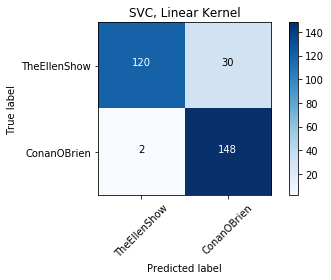

SVC, Poly Kernel: 87.33%



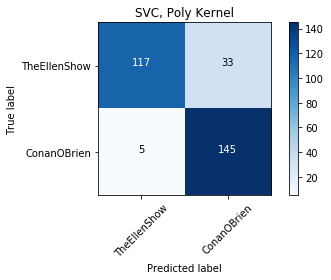

SVC, RBF Kernel: 87.67%



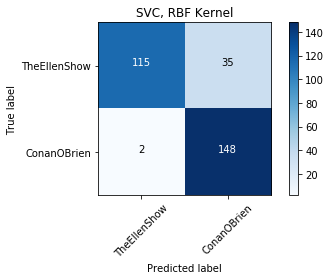

Naive Bayes: 76.67%



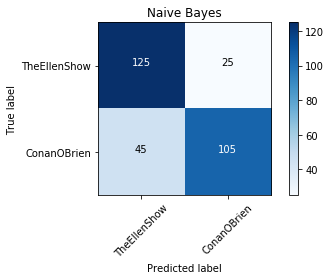

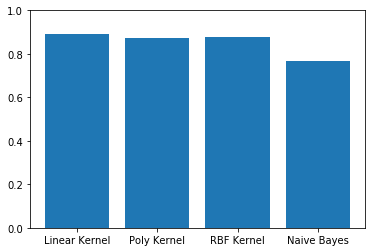

In [32]:
tweets_train = np.concatenate((tweets1_train, tweets2_train))
tweets_test = np.concatenate((tweets1_test, tweets2_test))
person_train = np.concatenate((person1_train, person2_train))
person_test = np.concatenate((person1_test, person2_test))
analyse(tweets_train, tweets_test, person_train, person_test, classes=('TheEllenShow','ConanOBrien'))

### FOR NOT SIMILAR PEOPLE

SVC, Linear Kernel: 87.33%



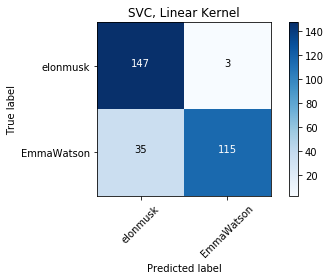

SVC, Poly Kernel: 87.67%



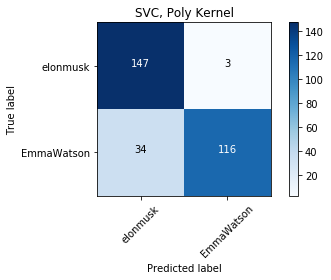

SVC, RBF Kernel: 92.33%



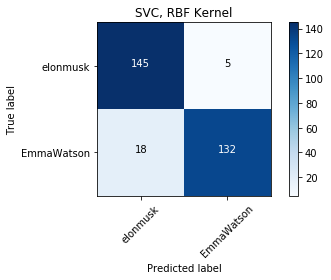

Naive Bayes: 89.33%



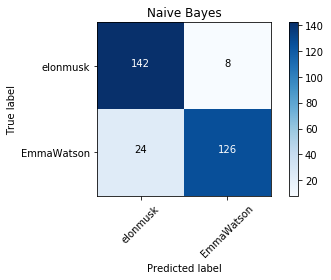

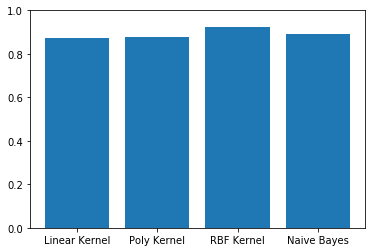

In [33]:
tweets_train = np.concatenate((tweets3_train, tweets4_train))
tweets_test = np.concatenate((tweets3_test, tweets4_test))
person_train = np.concatenate((person3_train, person4_train))
person_test = np.concatenate((person3_test, person4_test))
analyse(tweets_train, tweets_test, person_train, person_test, classes=('elonmusk','EmmaWatson'))

### FOR ALL PEOPLE

SVC, Linear Kernel: 77.83%



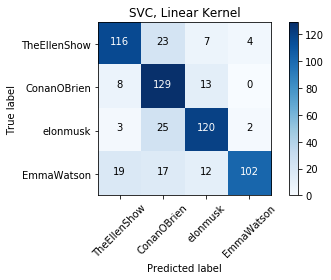

SVC, Poly Kernel: 78.50%



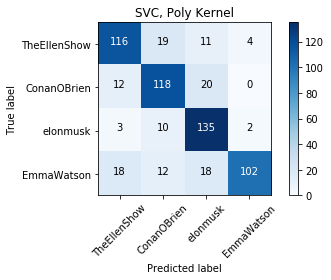

SVC, RBF Kernel: 78.50%



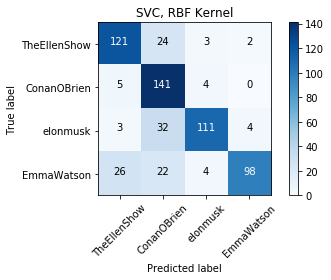

Naive Bayes: 71.00%



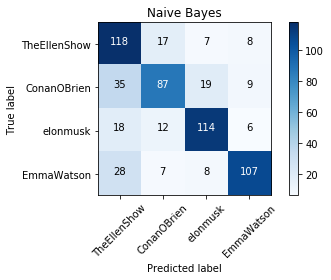

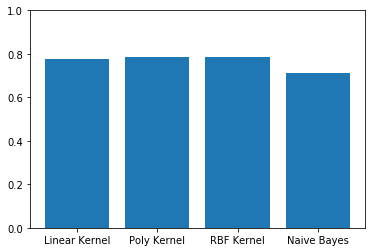

In [34]:
tweets_train = np.concatenate((tweets1_train, tweets2_train, tweets3_train, tweets4_train))
tweets_test = np.concatenate((tweets1_test, tweets2_test, tweets3_test, tweets4_test))
person_train = np.concatenate((person1_train, person2_train, person3_train, person4_train))
person_test = np.concatenate((person1_test, person2_test, person3_test, person4_test))
analyse(tweets_train, tweets_test, person_train, person_test, classes=('TheEllenShow','ConanOBrien','elonmusk','EmmaWatson'))

Finally we can conclude that the most applicable machine learning algorithm for our problem is SVC with rbf kernel with kernel coefficient equal to 0.7 (for similar people - 53.67% before appliying kernel coefficient versus __87.67%__ after, for not similar people - 65.00% versus __92.00%__) although SVCs with other kernels and applied parameters also showed great results with high percentage of correctly made predictions.   
We have applied the following parameters to improve results:
* C - penalty parameter C of the error term.
* degree - degree of the polynomial kernel function (‘poly’).
* gamma - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

In comparation, better results are achieved while analysing not similar people. It means that users with analogeous careers and way of living post tweets with very similar context since people which are really different from each other post completely various topics and it helps a lot to predict an owner of tweets because data is in a big contrast.

We also classified these four users at the same time. We got less accuracy as expected. This is explained by extra complexity given to the model. However it's always harder to work with more data, we achieved good accuracy after applying parameters (SVC with Linear Kernel - 77.83%, SVC with Poly Kernel - __78.50%__, SVC with RBF Kernel - __78.50%__, Naive Bayes - 71.00%).

### Basic analysis of feelings

In the last part of the assignment we have made basic analysis of feelings. For this we have used lists of positive and negative terms created by Bing and Liu.

We have created two lists: of __positive__ and __negative__ words. In every tweet of each person we check every word if it exists in list of positive or nrgstive words. We count all these words and as a result we have number of used positive and negative words per person.
Finally we count a global percentage of positive and negative terms in the tweets of each person.

In [35]:
pos = open('positive-words.txt', 'r')   
pos_words = pos.read().split()

neg = open('negative-words.txt', 'r')   
neg_words = neg.read().split()


for tweets, person in zip(list_tweets,list_people):
    n_positive = 0
    n_negative = 0
    n_words = 0
    for tweet in tweets:
        for word in tweet.split():
            n_words = n_words +1
            if word in pos_words:
                n_positive = n_positive +1z
            elif word in neg_words:
                n_negative = n_negative +1

    percentage_positive = (n_positive/n_words)*100            
    print(f"{person}. Percentage of positive words: {percentage_positive:.2f}%")

    percentage_negative = (n_negative/n_words)*100            
    print(f"{person}. Percentage of negative words: {percentage_negative:.2f}%")
    print()

TheEllenShow. Percentage of positive words: 3.36%
TheEllenShow. Percentage of negative words: 0.69%

ConanOBrien. Percentage of positive words: 2.31%
ConanOBrien. Percentage of negative words: 1.55%

elonmusk. Percentage of positive words: 2.95%
elonmusk. Percentage of negative words: 1.03%

EmmaWatson. Percentage of positive words: 3.21%
EmmaWatson. Percentage of negative words: 0.90%

